In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = True

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : False,
    'huntington'    : True,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'normalized','im':'t1','fe':['b25'],'fi':['roi']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_fa',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_0_t1t2_normalized_e_n_e_1_1_e_1_0_diffusion_fa_data_norm_b25_roi_t1_normalized_k5_b25_t1_1_42_n_normalized_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(684288, 276)
(684288, 1)
validation
(113488, 276)
(113488, 1)
test
(56512, 276)
(56512, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 276)]             0         


 dense (Dense)               (None, 1024)              283648    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 972801 (3.71 MB)


Trainable params: 972801 (3.71 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/69 [..............................] - ETA: 1:29 - loss: 0.0467 - STD: 8.3006e-05 - MAE: 0.1973

 5/69 [=>............................] - ETA: 0s - loss: 0.0252 - STD: 7.2163e-05 - MAE: 0.1245  

 9/69 [==>...........................] - ETA: 0s - loss: 0.0238 - STD: 5.9670e-05 - MAE: 0.1192

13/69 [====>.........................] - ETA: 0s - loss: 0.0202 - STD: 6.0851e-05 - MAE: 0.1085

17/69 [======>.......................] - ETA: 0s - loss: 0.0189 - STD: 6.7145e-05 - MAE: 0.1073

21/69 [========>.....................] - ETA: 0s - loss: 0.0175 - STD: 7.2963e-05 - MAE: 0.1031

25/69 [=========>....................] - ETA: 0s - loss: 0.0166 - STD: 7.7170e-05 - MAE: 0.0995

29/69 [===========>..................] - ETA: 0s - loss: 0.0160 - STD: 8.2803e-05 - MAE: 0.0969

31/69 [============>.................] - ETA: 1s - loss: 0.0157 - STD: 8.6616e-05 - MAE: 0.0960

35/69 [==============>...............] - ETA: 1s - loss: 0.0152 - STD: 9.5549e-05 - MAE: 0.0951

39/69 [===============>..............] - ETA: 0s - loss: 0.0148 - STD: 1.0396e-04 - MAE: 0.0940

43/69 [=================>............] - ETA: 0s - loss: 0.0144 - STD: 1.1152e-04 - MAE: 0.0926

47/69 [===================>..........] - ETA: 0s - loss: 0.0141 - STD: 1.1952e-04 - MAE: 0.0916

51/69 [=====================>........] - ETA: 0s - loss: 0.0139 - STD: 1.2898e-04 - MAE: 0.0910

55/69 [======================>.......] - ETA: 0s - loss: 0.0137 - STD: 1.3911e-04 - MAE: 0.0904

59/69 [========================>.....] - ETA: 0s - loss: 0.0135 - STD: 1.4892e-04 - MAE: 0.0898

63/69 [==========================>...] - ETA: 0s - loss: 0.0133 - STD: 1.5906e-04 - MAE: 0.0892

67/69 [============================>.] - ETA: 0s - loss: 0.0132 - STD: 1.7008e-04 - MAE: 0.0888

69/69 [==============================] - 4s 34ms/step - loss: 0.0131 - STD: 1.7591e-04 - MAE: 0.0887 - val_loss: 0.0125 - val_STD: 3.4901e-04 - val_MAE: 0.0864


Epoch 2/10000


 1/69 [..............................] - ETA: 2s - loss: 0.0105 - STD: 3.8373e-04 - MAE: 0.0814

 5/69 [=>............................] - ETA: 0s - loss: 0.0109 - STD: 3.9907e-04 - MAE: 0.0820

 9/69 [==>...........................] - ETA: 0s - loss: 0.0109 - STD: 4.1478e-04 - MAE: 0.0816

13/69 [====>.........................] - ETA: 0s - loss: 0.0109 - STD: 4.3513e-04 - MAE: 0.0818

17/69 [======>.......................] - ETA: 0s - loss: 0.0109 - STD: 4.5659e-04 - MAE: 0.0818

21/69 [========>.....................] - ETA: 0s - loss: 0.0109 - STD: 4.7941e-04 - MAE: 0.0818

25/69 [=========>....................] - ETA: 0s - loss: 0.0109 - STD: 5.0310e-04 - MAE: 0.0818

29/69 [===========>..................] - ETA: 0s - loss: 0.0109 - STD: 5.2805e-04 - MAE: 0.0819

33/69 [=============>................] - ETA: 0s - loss: 0.0109 - STD: 5.5579e-04 - MAE: 0.0819

37/69 [===============>..............] - ETA: 0s - loss: 0.0109 - STD: 5.8455e-04 - MAE: 0.0819

41/69 [================>.............] - ETA: 0s - loss: 0.0109 - STD: 6.1625e-04 - MAE: 0.0818

45/69 [==================>...........] - ETA: 0s - loss: 0.0109 - STD: 6.5065e-04 - MAE: 0.0818

49/69 [====================>.........] - ETA: 0s - loss: 0.0109 - STD: 6.8769e-04 - MAE: 0.0818

54/69 [======================>.......] - ETA: 0s - loss: 0.0109 - STD: 7.3839e-04 - MAE: 0.0818

58/69 [========================>.....] - ETA: 0s - loss: 0.0109 - STD: 7.8399e-04 - MAE: 0.0818

62/69 [=========================>....] - ETA: 0s - loss: 0.0109 - STD: 8.3431e-04 - MAE: 0.0818

66/69 [===========================>..] - ETA: 0s - loss: 0.0109 - STD: 8.9036e-04 - MAE: 0.0818

69/69 [==============================] - 1s 16ms/step - loss: 0.0109 - STD: 9.3665e-04 - MAE: 0.0817 - val_loss: 0.0125 - val_STD: 0.0019 - val_MAE: 0.0856


Epoch 3/10000


 1/69 [..............................] - ETA: 1s - loss: 0.0105 - STD: 0.0021 - MAE: 0.0804

 5/69 [=>............................] - ETA: 0s - loss: 0.0107 - STD: 0.0022 - MAE: 0.0812

 9/69 [==>...........................] - ETA: 0s - loss: 0.0108 - STD: 0.0024 - MAE: 0.0814

13/69 [====>.........................] - ETA: 0s - loss: 0.0108 - STD: 0.0025 - MAE: 0.0816

17/69 [======>.......................] - ETA: 0s - loss: 0.0108 - STD: 0.0027 - MAE: 0.0816

21/69 [========>.....................] - ETA: 0s - loss: 0.0107 - STD: 0.0030 - MAE: 0.0813

25/69 [=========>....................] - ETA: 0s - loss: 0.0107 - STD: 0.0032 - MAE: 0.0813

29/69 [===========>..................] - ETA: 0s - loss: 0.0107 - STD: 0.0036 - MAE: 0.0812

33/69 [=============>................] - ETA: 0s - loss: 0.0107 - STD: 0.0039 - MAE: 0.0811

37/69 [===============>..............] - ETA: 0s - loss: 0.0106 - STD: 0.0043 - MAE: 0.0809

41/69 [================>.............] - ETA: 0s - loss: 0.0105 - STD: 0.0048 - MAE: 0.0807

46/69 [===================>..........] - ETA: 0s - loss: 0.0105 - STD: 0.0056 - MAE: 0.0807

50/69 [====================>.........] - ETA: 0s - loss: 0.0105 - STD: 0.0063 - MAE: 0.0805

54/69 [======================>.......] - ETA: 0s - loss: 0.0104 - STD: 0.0072 - MAE: 0.0804

58/69 [========================>.....] - ETA: 0s - loss: 0.0104 - STD: 0.0081 - MAE: 0.0802

62/69 [=========================>....] - ETA: 0s - loss: 0.0103 - STD: 0.0092 - MAE: 0.0800

66/69 [===========================>..] - ETA: 0s - loss: 0.0103 - STD: 0.0104 - MAE: 0.0798

69/69 [==============================] - 1s 15ms/step - loss: 0.0102 - STD: 0.0114 - MAE: 0.0796 - val_loss: 0.0105 - val_STD: 0.0310 - val_MAE: 0.0801


Epoch 4/10000


 1/69 [..............................] - ETA: 2s - loss: 0.0093 - STD: 0.0347 - MAE: 0.0770

 5/69 [=>............................] - ETA: 0s - loss: 0.0091 - STD: 0.0357 - MAE: 0.0756

 9/69 [==>...........................] - ETA: 0s - loss: 0.0090 - STD: 0.0370 - MAE: 0.0753

14/69 [=====>........................] - ETA: 0s - loss: 0.0090 - STD: 0.0380 - MAE: 0.0751

18/69 [======>.......................] - ETA: 0s - loss: 0.0090 - STD: 0.0387 - MAE: 0.0747

22/69 [========>.....................] - ETA: 0s - loss: 0.0089 - STD: 0.0394 - MAE: 0.0745

26/69 [==========>...................] - ETA: 0s - loss: 0.0089 - STD: 0.0400 - MAE: 0.0743

30/69 [============>.................] - ETA: 0s - loss: 0.0088 - STD: 0.0404 - MAE: 0.0740

34/69 [=============>................] - ETA: 0s - loss: 0.0088 - STD: 0.0409 - MAE: 0.0738

38/69 [===============>..............] - ETA: 0s - loss: 0.0087 - STD: 0.0413 - MAE: 0.0736

42/69 [=================>............] - ETA: 0s - loss: 0.0087 - STD: 0.0417 - MAE: 0.0733

46/69 [===================>..........] - ETA: 0s - loss: 0.0086 - STD: 0.0421 - MAE: 0.0730

50/69 [====================>.........] - ETA: 0s - loss: 0.0085 - STD: 0.0426 - MAE: 0.0727

54/69 [======================>.......] - ETA: 0s - loss: 0.0085 - STD: 0.0431 - MAE: 0.0724

58/69 [========================>.....] - ETA: 0s - loss: 0.0084 - STD: 0.0437 - MAE: 0.0722

62/69 [=========================>....] - ETA: 0s - loss: 0.0084 - STD: 0.0443 - MAE: 0.0719

66/69 [===========================>..] - ETA: 0s - loss: 0.0083 - STD: 0.0450 - MAE: 0.0717

69/69 [==============================] - 1s 15ms/step - loss: 0.0083 - STD: 0.0454 - MAE: 0.0714 - val_loss: 0.0090 - val_STD: 0.0531 - val_MAE: 0.0752


Epoch 5/10000


 1/69 [..............................] - ETA: 2s - loss: 0.0072 - STD: 0.0552 - MAE: 0.0656

 5/69 [=>............................] - ETA: 0s - loss: 0.0073 - STD: 0.0558 - MAE: 0.0661

 9/69 [==>...........................] - ETA: 0s - loss: 0.0073 - STD: 0.0565 - MAE: 0.0660

13/69 [====>.........................] - ETA: 0s - loss: 0.0072 - STD: 0.0573 - MAE: 0.0660

18/69 [======>.......................] - ETA: 0s - loss: 0.0072 - STD: 0.0578 - MAE: 0.0658

22/69 [========>.....................] - ETA: 0s - loss: 0.0072 - STD: 0.0583 - MAE: 0.0657

26/69 [==========>...................] - ETA: 0s - loss: 0.0072 - STD: 0.0586 - MAE: 0.0654

30/69 [============>.................] - ETA: 0s - loss: 0.0071 - STD: 0.0590 - MAE: 0.0653

34/69 [=============>................] - ETA: 0s - loss: 0.0071 - STD: 0.0592 - MAE: 0.0652

38/69 [===============>..............] - ETA: 0s - loss: 0.0071 - STD: 0.0595 - MAE: 0.0652

42/69 [=================>............] - ETA: 0s - loss: 0.0071 - STD: 0.0598 - MAE: 0.0651

46/69 [===================>..........] - ETA: 0s - loss: 0.0071 - STD: 0.0600 - MAE: 0.0650

50/69 [====================>.........] - ETA: 0s - loss: 0.0071 - STD: 0.0603 - MAE: 0.0649

54/69 [======================>.......] - ETA: 0s - loss: 0.0070 - STD: 0.0604 - MAE: 0.0648

58/69 [========================>.....] - ETA: 0s - loss: 0.0070 - STD: 0.0607 - MAE: 0.0648

62/69 [=========================>....] - ETA: 0s - loss: 0.0070 - STD: 0.0608 - MAE: 0.0647

66/69 [===========================>..] - ETA: 0s - loss: 0.0070 - STD: 0.0609 - MAE: 0.0646

69/69 [==============================] - 1s 16ms/step - loss: 0.0070 - STD: 0.0610 - MAE: 0.0645 - val_loss: 0.0086 - val_STD: 0.0631 - val_MAE: 0.0733


Epoch 6/10000


 1/69 [..............................] - ETA: 2s - loss: 0.0067 - STD: 0.0619 - MAE: 0.0626

 5/69 [=>............................] - ETA: 0s - loss: 0.0067 - STD: 0.0637 - MAE: 0.0634

 9/69 [==>...........................] - ETA: 0s - loss: 0.0068 - STD: 0.0632 - MAE: 0.0633

13/69 [====>.........................] - ETA: 0s - loss: 0.0068 - STD: 0.0636 - MAE: 0.0635

17/69 [======>.......................] - ETA: 0s - loss: 0.0068 - STD: 0.0634 - MAE: 0.0635

22/69 [========>.....................] - ETA: 0s - loss: 0.0068 - STD: 0.0634 - MAE: 0.0634

26/69 [==========>...................] - ETA: 0s - loss: 0.0068 - STD: 0.0634 - MAE: 0.0633

30/69 [============>.................] - ETA: 0s - loss: 0.0068 - STD: 0.0636 - MAE: 0.0633

34/69 [=============>................] - ETA: 0s - loss: 0.0068 - STD: 0.0637 - MAE: 0.0632

38/69 [===============>..............] - ETA: 0s - loss: 0.0068 - STD: 0.0639 - MAE: 0.0633

42/69 [=================>............] - ETA: 0s - loss: 0.0068 - STD: 0.0639 - MAE: 0.0633

46/69 [===================>..........] - ETA: 0s - loss: 0.0067 - STD: 0.0640 - MAE: 0.0632

50/69 [====================>.........] - ETA: 0s - loss: 0.0067 - STD: 0.0640 - MAE: 0.0632

54/69 [======================>.......] - ETA: 0s - loss: 0.0067 - STD: 0.0640 - MAE: 0.0631

58/69 [========================>.....] - ETA: 0s - loss: 0.0067 - STD: 0.0640 - MAE: 0.0631

62/69 [=========================>....] - ETA: 0s - loss: 0.0067 - STD: 0.0642 - MAE: 0.0631

66/69 [===========================>..] - ETA: 0s - loss: 0.0067 - STD: 0.0642 - MAE: 0.0630

69/69 [==============================] - 1s 15ms/step - loss: 0.0067 - STD: 0.0642 - MAE: 0.0630 - val_loss: 0.0088 - val_STD: 0.0703 - val_MAE: 0.0758


Epoch 7/10000


 1/69 [..............................] - ETA: 2s - loss: 0.0067 - STD: 0.0673 - MAE: 0.0636

 5/69 [=>............................] - ETA: 0s - loss: 0.0068 - STD: 0.0653 - MAE: 0.0631

 9/69 [==>...........................] - ETA: 0s - loss: 0.0067 - STD: 0.0653 - MAE: 0.0627

13/69 [====>.........................] - ETA: 0s - loss: 0.0066 - STD: 0.0651 - MAE: 0.0624

17/69 [======>.......................] - ETA: 0s - loss: 0.0066 - STD: 0.0650 - MAE: 0.0624

21/69 [========>.....................] - ETA: 0s - loss: 0.0066 - STD: 0.0653 - MAE: 0.0625

25/69 [=========>....................] - ETA: 0s - loss: 0.0066 - STD: 0.0650 - MAE: 0.0625

29/69 [===========>..................] - ETA: 0s - loss: 0.0066 - STD: 0.0651 - MAE: 0.0625

33/69 [=============>................] - ETA: 0s - loss: 0.0066 - STD: 0.0649 - MAE: 0.0626

37/69 [===============>..............] - ETA: 0s - loss: 0.0066 - STD: 0.0649 - MAE: 0.0626

41/69 [================>.............] - ETA: 0s - loss: 0.0066 - STD: 0.0650 - MAE: 0.0626

45/69 [==================>...........] - ETA: 0s - loss: 0.0066 - STD: 0.0650 - MAE: 0.0625

50/69 [====================>.........] - ETA: 0s - loss: 0.0066 - STD: 0.0650 - MAE: 0.0626

54/69 [======================>.......] - ETA: 0s - loss: 0.0066 - STD: 0.0651 - MAE: 0.0626

58/69 [========================>.....] - ETA: 0s - loss: 0.0066 - STD: 0.0651 - MAE: 0.0625

62/69 [=========================>....] - ETA: 0s - loss: 0.0066 - STD: 0.0650 - MAE: 0.0625

66/69 [===========================>..] - ETA: 0s - loss: 0.0066 - STD: 0.0650 - MAE: 0.0625

69/69 [==============================] - 1s 15ms/step - loss: 0.0066 - STD: 0.0651 - MAE: 0.0625 - val_loss: 0.0087 - val_STD: 0.0720 - val_MAE: 0.0756


Epoch 8/10000


 1/69 [..............................] - ETA: 2s - loss: 0.0065 - STD: 0.0680 - MAE: 0.0626

 5/69 [=>............................] - ETA: 0s - loss: 0.0065 - STD: 0.0661 - MAE: 0.0619

 9/69 [==>...........................] - ETA: 0s - loss: 0.0065 - STD: 0.0665 - MAE: 0.0620

13/69 [====>.........................] - ETA: 0s - loss: 0.0065 - STD: 0.0662 - MAE: 0.0620

17/69 [======>.......................] - ETA: 0s - loss: 0.0065 - STD: 0.0661 - MAE: 0.0620

22/69 [========>.....................] - ETA: 0s - loss: 0.0066 - STD: 0.0658 - MAE: 0.0622

26/69 [==========>...................] - ETA: 0s - loss: 0.0065 - STD: 0.0656 - MAE: 0.0621

30/69 [============>.................] - ETA: 0s - loss: 0.0065 - STD: 0.0656 - MAE: 0.0621

34/69 [=============>................] - ETA: 0s - loss: 0.0065 - STD: 0.0656 - MAE: 0.0621

38/69 [===============>..............] - ETA: 0s - loss: 0.0065 - STD: 0.0657 - MAE: 0.0621

42/69 [=================>............] - ETA: 0s - loss: 0.0065 - STD: 0.0658 - MAE: 0.0620

46/69 [===================>..........] - ETA: 0s - loss: 0.0065 - STD: 0.0659 - MAE: 0.0620

50/69 [====================>.........] - ETA: 0s - loss: 0.0065 - STD: 0.0659 - MAE: 0.0620

54/69 [======================>.......] - ETA: 0s - loss: 0.0065 - STD: 0.0660 - MAE: 0.0620

58/69 [========================>.....] - ETA: 0s - loss: 0.0065 - STD: 0.0660 - MAE: 0.0620

62/69 [=========================>....] - ETA: 0s - loss: 0.0065 - STD: 0.0659 - MAE: 0.0620

66/69 [===========================>..] - ETA: 0s - loss: 0.0065 - STD: 0.0660 - MAE: 0.0620

69/69 [==============================] - 1s 16ms/step - loss: 0.0065 - STD: 0.0660 - MAE: 0.0619 - val_loss: 0.0083 - val_STD: 0.0712 - val_MAE: 0.0732


Epoch 9/10000


 1/69 [..............................] - ETA: 2s - loss: 0.0064 - STD: 0.0675 - MAE: 0.0617

 5/69 [=>............................] - ETA: 0s - loss: 0.0064 - STD: 0.0670 - MAE: 0.0615

 9/69 [==>...........................] - ETA: 0s - loss: 0.0064 - STD: 0.0669 - MAE: 0.0614

13/69 [====>.........................] - ETA: 0s - loss: 0.0064 - STD: 0.0666 - MAE: 0.0615

17/69 [======>.......................] - ETA: 0s - loss: 0.0064 - STD: 0.0665 - MAE: 0.0616

21/69 [========>.....................] - ETA: 0s - loss: 0.0064 - STD: 0.0663 - MAE: 0.0615

25/69 [=========>....................] - ETA: 0s - loss: 0.0064 - STD: 0.0662 - MAE: 0.0616

29/69 [===========>..................] - ETA: 0s - loss: 0.0065 - STD: 0.0662 - MAE: 0.0617

33/69 [=============>................] - ETA: 0s - loss: 0.0065 - STD: 0.0660 - MAE: 0.0617

37/69 [===============>..............] - ETA: 0s - loss: 0.0065 - STD: 0.0662 - MAE: 0.0619

41/69 [================>.............] - ETA: 0s - loss: 0.0066 - STD: 0.0656 - MAE: 0.0624

45/69 [==================>...........] - ETA: 0s - loss: 0.0067 - STD: 0.0648 - MAE: 0.0628

49/69 [====================>.........] - ETA: 0s - loss: 0.0068 - STD: 0.0640 - MAE: 0.0630

53/69 [======================>.......] - ETA: 0s - loss: 0.0068 - STD: 0.0634 - MAE: 0.0631

57/69 [=======================>......] - ETA: 0s - loss: 0.0068 - STD: 0.0632 - MAE: 0.0631

62/69 [=========================>....] - ETA: 0s - loss: 0.0067 - STD: 0.0634 - MAE: 0.0630

66/69 [===========================>..] - ETA: 0s - loss: 0.0067 - STD: 0.0636 - MAE: 0.0630

69/69 [==============================] - 1s 15ms/step - loss: 0.0067 - STD: 0.0639 - MAE: 0.0629 - val_loss: 0.0081 - val_STD: 0.0710 - val_MAE: 0.0723


Epoch 10/10000


 1/69 [..............................] - ETA: 2s - loss: 0.0064 - STD: 0.0662 - MAE: 0.0613

 5/69 [=>............................] - ETA: 0s - loss: 0.0065 - STD: 0.0670 - MAE: 0.0617

 9/69 [==>...........................] - ETA: 0s - loss: 0.0065 - STD: 0.0664 - MAE: 0.0618

13/69 [====>.........................] - ETA: 0s - loss: 0.0064 - STD: 0.0659 - MAE: 0.0617

18/69 [======>.......................] - ETA: 0s - loss: 0.0064 - STD: 0.0658 - MAE: 0.0617

22/69 [========>.....................] - ETA: 0s - loss: 0.0064 - STD: 0.0659 - MAE: 0.0617

26/69 [==========>...................] - ETA: 0s - loss: 0.0064 - STD: 0.0660 - MAE: 0.0617

30/69 [============>.................] - ETA: 0s - loss: 0.0064 - STD: 0.0661 - MAE: 0.0616

34/69 [=============>................] - ETA: 0s - loss: 0.0064 - STD: 0.0662 - MAE: 0.0616

38/69 [===============>..............] - ETA: 0s - loss: 0.0064 - STD: 0.0662 - MAE: 0.0616

42/69 [=================>............] - ETA: 0s - loss: 0.0064 - STD: 0.0662 - MAE: 0.0616

46/69 [===================>..........] - ETA: 0s - loss: 0.0064 - STD: 0.0661 - MAE: 0.0616

50/69 [====================>.........] - ETA: 0s - loss: 0.0064 - STD: 0.0661 - MAE: 0.0616

54/69 [======================>.......] - ETA: 0s - loss: 0.0064 - STD: 0.0662 - MAE: 0.0615

58/69 [========================>.....] - ETA: 0s - loss: 0.0064 - STD: 0.0663 - MAE: 0.0615

62/69 [=========================>....] - ETA: 0s - loss: 0.0064 - STD: 0.0664 - MAE: 0.0615

66/69 [===========================>..] - ETA: 0s - loss: 0.0064 - STD: 0.0665 - MAE: 0.0615

69/69 [==============================] - 1s 15ms/step - loss: 0.0064 - STD: 0.0665 - MAE: 0.0615 - val_loss: 0.0083 - val_STD: 0.0724 - val_MAE: 0.0739


Epoch 11/10000


 1/69 [..............................] - ETA: 2s - loss: 0.0063 - STD: 0.0679 - MAE: 0.0608

 5/69 [=>............................] - ETA: 0s - loss: 0.0063 - STD: 0.0667 - MAE: 0.0607

 9/69 [==>...........................] - ETA: 0s - loss: 0.0063 - STD: 0.0666 - MAE: 0.0607

13/69 [====>.........................] - ETA: 0s - loss: 0.0063 - STD: 0.0667 - MAE: 0.0610

17/69 [======>.......................] - ETA: 0s - loss: 0.0063 - STD: 0.0668 - MAE: 0.0610

22/69 [========>.....................] - ETA: 0s - loss: 0.0063 - STD: 0.0667 - MAE: 0.0610

26/69 [==========>...................] - ETA: 0s - loss: 0.0063 - STD: 0.0668 - MAE: 0.0610

30/69 [============>.................] - ETA: 0s - loss: 0.0064 - STD: 0.0668 - MAE: 0.0611

34/69 [=============>................] - ETA: 0s - loss: 0.0063 - STD: 0.0669 - MAE: 0.0610

38/69 [===============>..............] - ETA: 0s - loss: 0.0063 - STD: 0.0670 - MAE: 0.0610

42/69 [=================>............] - ETA: 0s - loss: 0.0063 - STD: 0.0670 - MAE: 0.0611

46/69 [===================>..........] - ETA: 0s - loss: 0.0063 - STD: 0.0670 - MAE: 0.0611

50/69 [====================>.........] - ETA: 0s - loss: 0.0063 - STD: 0.0670 - MAE: 0.0610

54/69 [======================>.......] - ETA: 0s - loss: 0.0063 - STD: 0.0670 - MAE: 0.0610

58/69 [========================>.....] - ETA: 0s - loss: 0.0063 - STD: 0.0670 - MAE: 0.0610

62/69 [=========================>....] - ETA: 0s - loss: 0.0063 - STD: 0.0670 - MAE: 0.0610

66/69 [===========================>..] - ETA: 0s - loss: 0.0063 - STD: 0.0671 - MAE: 0.0611

69/69 [==============================] - 1s 15ms/step - loss: 0.0063 - STD: 0.0671 - MAE: 0.0611 - val_loss: 0.0080 - val_STD: 0.0710 - val_MAE: 0.0722


Epoch 12/10000


 1/69 [..............................] - ETA: 1s - loss: 0.0064 - STD: 0.0659 - MAE: 0.0606

 5/69 [=>............................] - ETA: 0s - loss: 0.0063 - STD: 0.0663 - MAE: 0.0606

 9/69 [==>...........................] - ETA: 0s - loss: 0.0063 - STD: 0.0667 - MAE: 0.0608

13/69 [====>.........................] - ETA: 0s - loss: 0.0063 - STD: 0.0666 - MAE: 0.0609

17/69 [======>.......................] - ETA: 0s - loss: 0.0063 - STD: 0.0667 - MAE: 0.0608

21/69 [========>.....................] - ETA: 0s - loss: 0.0063 - STD: 0.0667 - MAE: 0.0608

25/69 [=========>....................] - ETA: 0s - loss: 0.0063 - STD: 0.0669 - MAE: 0.0610

29/69 [===========>..................] - ETA: 0s - loss: 0.0063 - STD: 0.0669 - MAE: 0.0610

33/69 [=============>................] - ETA: 0s - loss: 0.0063 - STD: 0.0669 - MAE: 0.0609

37/69 [===============>..............] - ETA: 0s - loss: 0.0063 - STD: 0.0669 - MAE: 0.0609

42/69 [=================>............] - ETA: 0s - loss: 0.0063 - STD: 0.0670 - MAE: 0.0609

46/69 [===================>..........] - ETA: 0s - loss: 0.0063 - STD: 0.0671 - MAE: 0.0610

50/69 [====================>.........] - ETA: 0s - loss: 0.0063 - STD: 0.0671 - MAE: 0.0609

54/69 [======================>.......] - ETA: 0s - loss: 0.0063 - STD: 0.0671 - MAE: 0.0609

58/69 [========================>.....] - ETA: 0s - loss: 0.0063 - STD: 0.0671 - MAE: 0.0609

62/69 [=========================>....] - ETA: 0s - loss: 0.0063 - STD: 0.0671 - MAE: 0.0609

66/69 [===========================>..] - ETA: 0s - loss: 0.0063 - STD: 0.0671 - MAE: 0.0610

69/69 [==============================] - 1s 15ms/step - loss: 0.0063 - STD: 0.0671 - MAE: 0.0610 - val_loss: 0.0078 - val_STD: 0.0694 - val_MAE: 0.0713


Epoch 13/10000


 1/69 [..............................] - ETA: 1s - loss: 0.0063 - STD: 0.0637 - MAE: 0.0598

 5/69 [=>............................] - ETA: 0s - loss: 0.0064 - STD: 0.0649 - MAE: 0.0609

 9/69 [==>...........................] - ETA: 0s - loss: 0.0064 - STD: 0.0663 - MAE: 0.0611

13/69 [====>.........................] - ETA: 0s - loss: 0.0063 - STD: 0.0667 - MAE: 0.0610

17/69 [======>.......................] - ETA: 0s - loss: 0.0064 - STD: 0.0667 - MAE: 0.0610

21/69 [========>.....................] - ETA: 0s - loss: 0.0064 - STD: 0.0666 - MAE: 0.0610

25/69 [=========>....................] - ETA: 0s - loss: 0.0063 - STD: 0.0667 - MAE: 0.0609

29/69 [===========>..................] - ETA: 0s - loss: 0.0063 - STD: 0.0667 - MAE: 0.0609

33/69 [=============>................] - ETA: 0s - loss: 0.0063 - STD: 0.0670 - MAE: 0.0609

37/69 [===============>..............] - ETA: 0s - loss: 0.0063 - STD: 0.0672 - MAE: 0.0609

41/69 [================>.............] - ETA: 0s - loss: 0.0063 - STD: 0.0671 - MAE: 0.0609

45/69 [==================>...........] - ETA: 0s - loss: 0.0063 - STD: 0.0671 - MAE: 0.0608

49/69 [====================>.........] - ETA: 0s - loss: 0.0063 - STD: 0.0672 - MAE: 0.0608

53/69 [======================>.......] - ETA: 0s - loss: 0.0063 - STD: 0.0672 - MAE: 0.0608

57/69 [=======================>......] - ETA: 0s - loss: 0.0063 - STD: 0.0672 - MAE: 0.0608

61/69 [=========================>....] - ETA: 0s - loss: 0.0063 - STD: 0.0673 - MAE: 0.0607

65/69 [===========================>..] - ETA: 0s - loss: 0.0063 - STD: 0.0673 - MAE: 0.0607

69/69 [==============================] - 1s 15ms/step - loss: 0.0063 - STD: 0.0674 - MAE: 0.0607 - val_loss: 0.0080 - val_STD: 0.0732 - val_MAE: 0.0726


Epoch 14/10000


 1/69 [..............................] - ETA: 2s - loss: 0.0061 - STD: 0.0670 - MAE: 0.0596

 5/69 [=>............................] - ETA: 0s - loss: 0.0063 - STD: 0.0677 - MAE: 0.0605

 9/69 [==>...........................] - ETA: 0s - loss: 0.0063 - STD: 0.0679 - MAE: 0.0606

13/69 [====>.........................] - ETA: 0s - loss: 0.0063 - STD: 0.0673 - MAE: 0.0605

17/69 [======>.......................] - ETA: 0s - loss: 0.0063 - STD: 0.0672 - MAE: 0.0606

21/69 [========>.....................] - ETA: 0s - loss: 0.0063 - STD: 0.0675 - MAE: 0.0606

25/69 [=========>....................] - ETA: 0s - loss: 0.0063 - STD: 0.0674 - MAE: 0.0606

29/69 [===========>..................] - ETA: 0s - loss: 0.0063 - STD: 0.0675 - MAE: 0.0607

33/69 [=============>................] - ETA: 0s - loss: 0.0063 - STD: 0.0674 - MAE: 0.0607

37/69 [===============>..............] - ETA: 0s - loss: 0.0063 - STD: 0.0673 - MAE: 0.0607

41/69 [================>.............] - ETA: 0s - loss: 0.0063 - STD: 0.0674 - MAE: 0.0606

45/69 [==================>...........] - ETA: 0s - loss: 0.0063 - STD: 0.0676 - MAE: 0.0606

49/69 [====================>.........] - ETA: 0s - loss: 0.0063 - STD: 0.0675 - MAE: 0.0606

53/69 [======================>.......] - ETA: 0s - loss: 0.0063 - STD: 0.0676 - MAE: 0.0606

57/69 [=======================>......] - ETA: 0s - loss: 0.0063 - STD: 0.0676 - MAE: 0.0606

62/69 [=========================>....] - ETA: 0s - loss: 0.0063 - STD: 0.0675 - MAE: 0.0606

66/69 [===========================>..] - ETA: 0s - loss: 0.0063 - STD: 0.0676 - MAE: 0.0606

69/69 [==============================] - 1s 15ms/step - loss: 0.0063 - STD: 0.0676 - MAE: 0.0606 - val_loss: 0.0082 - val_STD: 0.0747 - val_MAE: 0.0734


Epoch 15/10000


 1/69 [..............................] - ETA: 2s - loss: 0.0064 - STD: 0.0682 - MAE: 0.0603

 5/69 [=>............................] - ETA: 0s - loss: 0.0063 - STD: 0.0687 - MAE: 0.0605

 9/69 [==>...........................] - ETA: 0s - loss: 0.0063 - STD: 0.0687 - MAE: 0.0605

13/69 [====>.........................] - ETA: 0s - loss: 0.0063 - STD: 0.0683 - MAE: 0.0605

17/69 [======>.......................] - ETA: 0s - loss: 0.0063 - STD: 0.0683 - MAE: 0.0605

21/69 [========>.....................] - ETA: 0s - loss: 0.0062 - STD: 0.0684 - MAE: 0.0604

25/69 [=========>....................] - ETA: 0s - loss: 0.0062 - STD: 0.0685 - MAE: 0.0603

29/69 [===========>..................] - ETA: 0s - loss: 0.0062 - STD: 0.0682 - MAE: 0.0603

33/69 [=============>................] - ETA: 0s - loss: 0.0062 - STD: 0.0681 - MAE: 0.0604

37/69 [===============>..............] - ETA: 0s - loss: 0.0062 - STD: 0.0680 - MAE: 0.0604

41/69 [================>.............] - ETA: 0s - loss: 0.0062 - STD: 0.0680 - MAE: 0.0604

45/69 [==================>...........] - ETA: 0s - loss: 0.0062 - STD: 0.0681 - MAE: 0.0604

49/69 [====================>.........] - ETA: 0s - loss: 0.0062 - STD: 0.0681 - MAE: 0.0603

53/69 [======================>.......] - ETA: 0s - loss: 0.0062 - STD: 0.0682 - MAE: 0.0603

57/69 [=======================>......] - ETA: 0s - loss: 0.0062 - STD: 0.0683 - MAE: 0.0603

61/69 [=========================>....] - ETA: 0s - loss: 0.0062 - STD: 0.0682 - MAE: 0.0603

66/69 [===========================>..] - ETA: 0s - loss: 0.0062 - STD: 0.0682 - MAE: 0.0604

69/69 [==============================] - 1s 16ms/step - loss: 0.0062 - STD: 0.0682 - MAE: 0.0604 - val_loss: 0.0077 - val_STD: 0.0700 - val_MAE: 0.0698


Epoch 16/10000


 1/69 [..............................] - ETA: 2s - loss: 0.0063 - STD: 0.0629 - MAE: 0.0596

 5/69 [=>............................] - ETA: 0s - loss: 0.0064 - STD: 0.0658 - MAE: 0.0607

 9/69 [==>...........................] - ETA: 0s - loss: 0.0065 - STD: 0.0671 - MAE: 0.0617

13/69 [====>.........................] - ETA: 0s - loss: 0.0067 - STD: 0.0660 - MAE: 0.0621

17/69 [======>.......................] - ETA: 0s - loss: 0.0067 - STD: 0.0650 - MAE: 0.0625

21/69 [========>.....................] - ETA: 0s - loss: 0.0067 - STD: 0.0643 - MAE: 0.0625

25/69 [=========>....................] - ETA: 0s - loss: 0.0067 - STD: 0.0641 - MAE: 0.0625

29/69 [===========>..................] - ETA: 0s - loss: 0.0067 - STD: 0.0645 - MAE: 0.0624

33/69 [=============>................] - ETA: 0s - loss: 0.0066 - STD: 0.0649 - MAE: 0.0622

37/69 [===============>..............] - ETA: 0s - loss: 0.0066 - STD: 0.0651 - MAE: 0.0620

42/69 [=================>............] - ETA: 0s - loss: 0.0065 - STD: 0.0654 - MAE: 0.0618

46/69 [===================>..........] - ETA: 0s - loss: 0.0065 - STD: 0.0656 - MAE: 0.0616

50/69 [====================>.........] - ETA: 0s - loss: 0.0065 - STD: 0.0658 - MAE: 0.0615

54/69 [======================>.......] - ETA: 0s - loss: 0.0065 - STD: 0.0660 - MAE: 0.0614

58/69 [========================>.....] - ETA: 0s - loss: 0.0064 - STD: 0.0663 - MAE: 0.0613

62/69 [=========================>....] - ETA: 0s - loss: 0.0064 - STD: 0.0664 - MAE: 0.0612

66/69 [===========================>..] - ETA: 0s - loss: 0.0064 - STD: 0.0666 - MAE: 0.0611

69/69 [==============================] - 1s 15ms/step - loss: 0.0064 - STD: 0.0666 - MAE: 0.0611 - val_loss: 0.0080 - val_STD: 0.0731 - val_MAE: 0.0727


Epoch 17/10000


 1/69 [..............................] - ETA: 2s - loss: 0.0061 - STD: 0.0666 - MAE: 0.0595

 5/69 [=>............................] - ETA: 0s - loss: 0.0062 - STD: 0.0680 - MAE: 0.0598

 9/69 [==>...........................] - ETA: 0s - loss: 0.0062 - STD: 0.0681 - MAE: 0.0600

14/69 [=====>........................] - ETA: 0s - loss: 0.0062 - STD: 0.0682 - MAE: 0.0602

18/69 [======>.......................] - ETA: 0s - loss: 0.0062 - STD: 0.0681 - MAE: 0.0602

22/69 [========>.....................] - ETA: 0s - loss: 0.0062 - STD: 0.0682 - MAE: 0.0601

26/69 [==========>...................] - ETA: 0s - loss: 0.0061 - STD: 0.0683 - MAE: 0.0600

30/69 [============>.................] - ETA: 0s - loss: 0.0062 - STD: 0.0683 - MAE: 0.0600

34/69 [=============>................] - ETA: 0s - loss: 0.0062 - STD: 0.0684 - MAE: 0.0600

38/69 [===============>..............] - ETA: 0s - loss: 0.0062 - STD: 0.0685 - MAE: 0.0601

42/69 [=================>............] - ETA: 0s - loss: 0.0062 - STD: 0.0685 - MAE: 0.0601

46/69 [===================>..........] - ETA: 0s - loss: 0.0062 - STD: 0.0686 - MAE: 0.0601

50/69 [====================>.........] - ETA: 0s - loss: 0.0062 - STD: 0.0686 - MAE: 0.0601

54/69 [======================>.......] - ETA: 0s - loss: 0.0062 - STD: 0.0686 - MAE: 0.0601

58/69 [========================>.....] - ETA: 0s - loss: 0.0062 - STD: 0.0686 - MAE: 0.0601

62/69 [=========================>....] - ETA: 0s - loss: 0.0062 - STD: 0.0686 - MAE: 0.0601

66/69 [===========================>..] - ETA: 0s - loss: 0.0062 - STD: 0.0687 - MAE: 0.0601

69/69 [==============================] - 1s 15ms/step - loss: 0.0062 - STD: 0.0687 - MAE: 0.0601 - val_loss: 0.0080 - val_STD: 0.0740 - val_MAE: 0.0724


Epoch 18/10000


 1/69 [..............................] - ETA: 2s - loss: 0.0060 - STD: 0.0676 - MAE: 0.0586

 5/69 [=>............................] - ETA: 0s - loss: 0.0062 - STD: 0.0684 - MAE: 0.0597

 9/69 [==>...........................] - ETA: 0s - loss: 0.0062 - STD: 0.0683 - MAE: 0.0599

13/69 [====>.........................] - ETA: 0s - loss: 0.0061 - STD: 0.0685 - MAE: 0.0598

17/69 [======>.......................] - ETA: 0s - loss: 0.0062 - STD: 0.0689 - MAE: 0.0599

21/69 [========>.....................] - ETA: 0s - loss: 0.0062 - STD: 0.0689 - MAE: 0.0599

25/69 [=========>....................] - ETA: 0s - loss: 0.0062 - STD: 0.0686 - MAE: 0.0599

29/69 [===========>..................] - ETA: 0s - loss: 0.0062 - STD: 0.0685 - MAE: 0.0599

33/69 [=============>................] - ETA: 0s - loss: 0.0062 - STD: 0.0686 - MAE: 0.0600

37/69 [===============>..............] - ETA: 0s - loss: 0.0062 - STD: 0.0686 - MAE: 0.0600

41/69 [================>.............] - ETA: 0s - loss: 0.0062 - STD: 0.0686 - MAE: 0.0599

45/69 [==================>...........] - ETA: 0s - loss: 0.0062 - STD: 0.0686 - MAE: 0.0600

49/69 [====================>.........] - ETA: 0s - loss: 0.0062 - STD: 0.0687 - MAE: 0.0600

53/69 [======================>.......] - ETA: 0s - loss: 0.0062 - STD: 0.0688 - MAE: 0.0600

57/69 [=======================>......] - ETA: 0s - loss: 0.0062 - STD: 0.0688 - MAE: 0.0600

61/69 [=========================>....] - ETA: 0s - loss: 0.0062 - STD: 0.0688 - MAE: 0.0600

65/69 [===========================>..] - ETA: 0s - loss: 0.0062 - STD: 0.0687 - MAE: 0.0600

69/69 [==============================] - 1s 15ms/step - loss: 0.0062 - STD: 0.0687 - MAE: 0.0601 - val_loss: 0.0085 - val_STD: 0.0767 - val_MAE: 0.0755


Epoch 19/10000


 1/69 [..............................] - ETA: 2s - loss: 0.0061 - STD: 0.0695 - MAE: 0.0596

 5/69 [=>............................] - ETA: 0s - loss: 0.0061 - STD: 0.0697 - MAE: 0.0597

 9/69 [==>...........................] - ETA: 0s - loss: 0.0061 - STD: 0.0697 - MAE: 0.0598

13/69 [====>.........................] - ETA: 0s - loss: 0.0061 - STD: 0.0694 - MAE: 0.0598

17/69 [======>.......................] - ETA: 0s - loss: 0.0061 - STD: 0.0691 - MAE: 0.0598

21/69 [========>.....................] - ETA: 0s - loss: 0.0061 - STD: 0.0689 - MAE: 0.0599

25/69 [=========>....................] - ETA: 0s - loss: 0.0062 - STD: 0.0691 - MAE: 0.0600

29/69 [===========>..................] - ETA: 0s - loss: 0.0062 - STD: 0.0692 - MAE: 0.0599

33/69 [=============>................] - ETA: 0s - loss: 0.0062 - STD: 0.0693 - MAE: 0.0599

38/69 [===============>..............] - ETA: 0s - loss: 0.0062 - STD: 0.0691 - MAE: 0.0599

42/69 [=================>............] - ETA: 0s - loss: 0.0062 - STD: 0.0692 - MAE: 0.0600

46/69 [===================>..........] - ETA: 0s - loss: 0.0062 - STD: 0.0691 - MAE: 0.0600

50/69 [====================>.........] - ETA: 0s - loss: 0.0062 - STD: 0.0690 - MAE: 0.0599

54/69 [======================>.......] - ETA: 0s - loss: 0.0062 - STD: 0.0691 - MAE: 0.0599

58/69 [========================>.....] - ETA: 0s - loss: 0.0062 - STD: 0.0691 - MAE: 0.0599

62/69 [=========================>....] - ETA: 0s - loss: 0.0062 - STD: 0.0691 - MAE: 0.0599

66/69 [===========================>..] - ETA: 0s - loss: 0.0062 - STD: 0.0691 - MAE: 0.0599

69/69 [==============================] - 1s 16ms/step - loss: 0.0062 - STD: 0.0691 - MAE: 0.0599 - val_loss: 0.0085 - val_STD: 0.0762 - val_MAE: 0.0754


Epoch 20/10000


 1/69 [..............................] - ETA: 1s - loss: 0.0062 - STD: 0.0703 - MAE: 0.0603

 5/69 [=>............................] - ETA: 0s - loss: 0.0062 - STD: 0.0690 - MAE: 0.0599

 9/69 [==>...........................] - ETA: 0s - loss: 0.0062 - STD: 0.0691 - MAE: 0.0598

13/69 [====>.........................] - ETA: 0s - loss: 0.0062 - STD: 0.0692 - MAE: 0.0601

17/69 [======>.......................] - ETA: 0s - loss: 0.0062 - STD: 0.0687 - MAE: 0.0602

21/69 [========>.....................] - ETA: 0s - loss: 0.0062 - STD: 0.0688 - MAE: 0.0602

25/69 [=========>....................] - ETA: 0s - loss: 0.0062 - STD: 0.0689 - MAE: 0.0602

29/69 [===========>..................] - ETA: 0s - loss: 0.0062 - STD: 0.0689 - MAE: 0.0602

33/69 [=============>................] - ETA: 0s - loss: 0.0062 - STD: 0.0690 - MAE: 0.0601

37/69 [===============>..............] - ETA: 0s - loss: 0.0062 - STD: 0.0690 - MAE: 0.0601

41/69 [================>.............] - ETA: 0s - loss: 0.0062 - STD: 0.0689 - MAE: 0.0601

45/69 [==================>...........] - ETA: 0s - loss: 0.0062 - STD: 0.0690 - MAE: 0.0602

49/69 [====================>.........] - ETA: 0s - loss: 0.0062 - STD: 0.0688 - MAE: 0.0603

53/69 [======================>.......] - ETA: 0s - loss: 0.0062 - STD: 0.0686 - MAE: 0.0603

57/69 [=======================>......] - ETA: 0s - loss: 0.0062 - STD: 0.0685 - MAE: 0.0603

61/69 [=========================>....] - ETA: 0s - loss: 0.0062 - STD: 0.0686 - MAE: 0.0602

65/69 [===========================>..] - ETA: 0s - loss: 0.0062 - STD: 0.0686 - MAE: 0.0602

69/69 [==============================] - ETA: 0s - loss: 0.0062 - STD: 0.0686 - MAE: 0.0601

69/69 [==============================] - 1s 15ms/step - loss: 0.0062 - STD: 0.0686 - MAE: 0.0601 - val_loss: 0.0085 - val_STD: 0.0765 - val_MAE: 0.0757


Epoch 21/10000


 1/69 [..............................] - ETA: 2s - loss: 0.0063 - STD: 0.0694 - MAE: 0.0606

 5/69 [=>............................] - ETA: 0s - loss: 0.0062 - STD: 0.0691 - MAE: 0.0600

 9/69 [==>...........................] - ETA: 0s - loss: 0.0061 - STD: 0.0694 - MAE: 0.0597

13/69 [====>.........................] - ETA: 0s - loss: 0.0061 - STD: 0.0694 - MAE: 0.0596

17/69 [======>.......................] - ETA: 0s - loss: 0.0061 - STD: 0.0694 - MAE: 0.0596

21/69 [========>.....................] - ETA: 0s - loss: 0.0061 - STD: 0.0694 - MAE: 0.0596

25/69 [=========>....................] - ETA: 0s - loss: 0.0061 - STD: 0.0694 - MAE: 0.0596

29/69 [===========>..................] - ETA: 0s - loss: 0.0061 - STD: 0.0694 - MAE: 0.0596

33/69 [=============>................] - ETA: 0s - loss: 0.0061 - STD: 0.0694 - MAE: 0.0596

37/69 [===============>..............] - ETA: 0s - loss: 0.0061 - STD: 0.0694 - MAE: 0.0596

41/69 [================>.............] - ETA: 0s - loss: 0.0061 - STD: 0.0694 - MAE: 0.0597

45/69 [==================>...........] - ETA: 0s - loss: 0.0061 - STD: 0.0693 - MAE: 0.0597

50/69 [====================>.........] - ETA: 0s - loss: 0.0061 - STD: 0.0693 - MAE: 0.0598

54/69 [======================>.......] - ETA: 0s - loss: 0.0061 - STD: 0.0692 - MAE: 0.0598

58/69 [========================>.....] - ETA: 0s - loss: 0.0061 - STD: 0.0691 - MAE: 0.0598

62/69 [=========================>....] - ETA: 0s - loss: 0.0061 - STD: 0.0692 - MAE: 0.0598

66/69 [===========================>..] - ETA: 0s - loss: 0.0061 - STD: 0.0692 - MAE: 0.0598

69/69 [==============================] - 1s 16ms/step - loss: 0.0061 - STD: 0.0692 - MAE: 0.0598 - val_loss: 0.0081 - val_STD: 0.0747 - val_MAE: 0.0732


Epoch 22/10000


 1/69 [..............................] - ETA: 2s - loss: 0.0061 - STD: 0.0677 - MAE: 0.0593

 5/69 [=>............................] - ETA: 0s - loss: 0.0062 - STD: 0.0687 - MAE: 0.0599

 9/69 [==>...........................] - ETA: 0s - loss: 0.0062 - STD: 0.0696 - MAE: 0.0602

13/69 [====>.........................] - ETA: 0s - loss: 0.0062 - STD: 0.0693 - MAE: 0.0599

17/69 [======>.......................] - ETA: 0s - loss: 0.0062 - STD: 0.0690 - MAE: 0.0599

21/69 [========>.....................] - ETA: 0s - loss: 0.0062 - STD: 0.0688 - MAE: 0.0601

25/69 [=========>....................] - ETA: 0s - loss: 0.0062 - STD: 0.0687 - MAE: 0.0601

29/69 [===========>..................] - ETA: 0s - loss: 0.0062 - STD: 0.0685 - MAE: 0.0601

33/69 [=============>................] - ETA: 0s - loss: 0.0062 - STD: 0.0687 - MAE: 0.0601

37/69 [===============>..............] - ETA: 0s - loss: 0.0062 - STD: 0.0688 - MAE: 0.0601

41/69 [================>.............] - ETA: 0s - loss: 0.0062 - STD: 0.0688 - MAE: 0.0601

46/69 [===================>..........] - ETA: 0s - loss: 0.0062 - STD: 0.0688 - MAE: 0.0600

50/69 [====================>.........] - ETA: 0s - loss: 0.0062 - STD: 0.0689 - MAE: 0.0600

54/69 [======================>.......] - ETA: 0s - loss: 0.0062 - STD: 0.0690 - MAE: 0.0600

58/69 [========================>.....] - ETA: 0s - loss: 0.0062 - STD: 0.0689 - MAE: 0.0600

62/69 [=========================>....] - ETA: 0s - loss: 0.0062 - STD: 0.0689 - MAE: 0.0600

66/69 [===========================>..] - ETA: 0s - loss: 0.0062 - STD: 0.0689 - MAE: 0.0600

69/69 [==============================] - 1s 15ms/step - loss: 0.0062 - STD: 0.0690 - MAE: 0.0599 - val_loss: 0.0086 - val_STD: 0.0777 - val_MAE: 0.0757


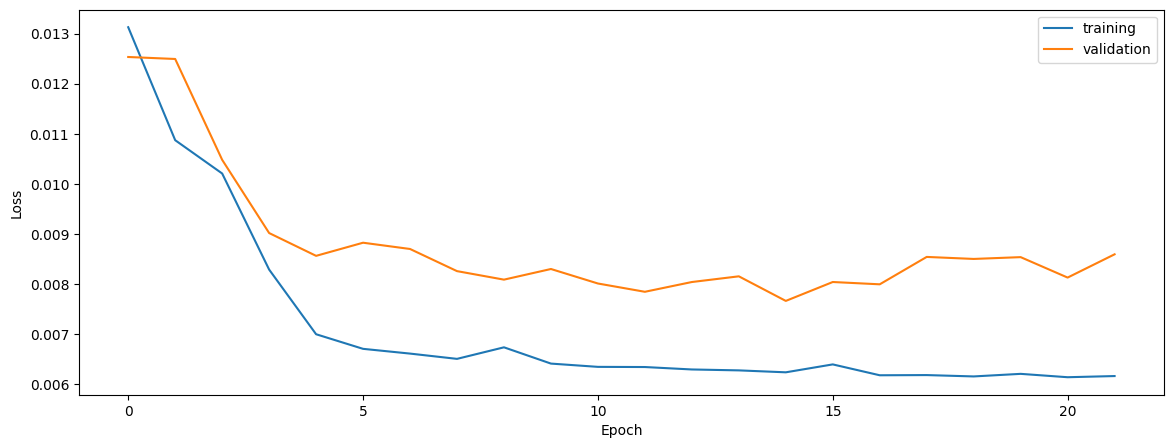

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getPearson(train[1],train[4]))
print(getPearson(val[1],val[4]))
print(getPearson(test[1],test[4]))

train
0.6601405088565543
0.6274392510909452
0.601254023137753


In [8]:
print(props['space'])
print(getPearson(train[1],train[4],train[3][0]))
print(getPearson(val[1],val[4],val[3][0]))
print(getPearson(test[1],test[4],test[3][0]))

normalized
0.6386378949445685
0.6207655186155434
0.6270973368683699


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getPearson(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getPearson(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getPearson(test[1][test[2]],test[4][test[2]],test[3][1]))

native
0.6471699225104277
0.6281778297246379
0.6374993521957859


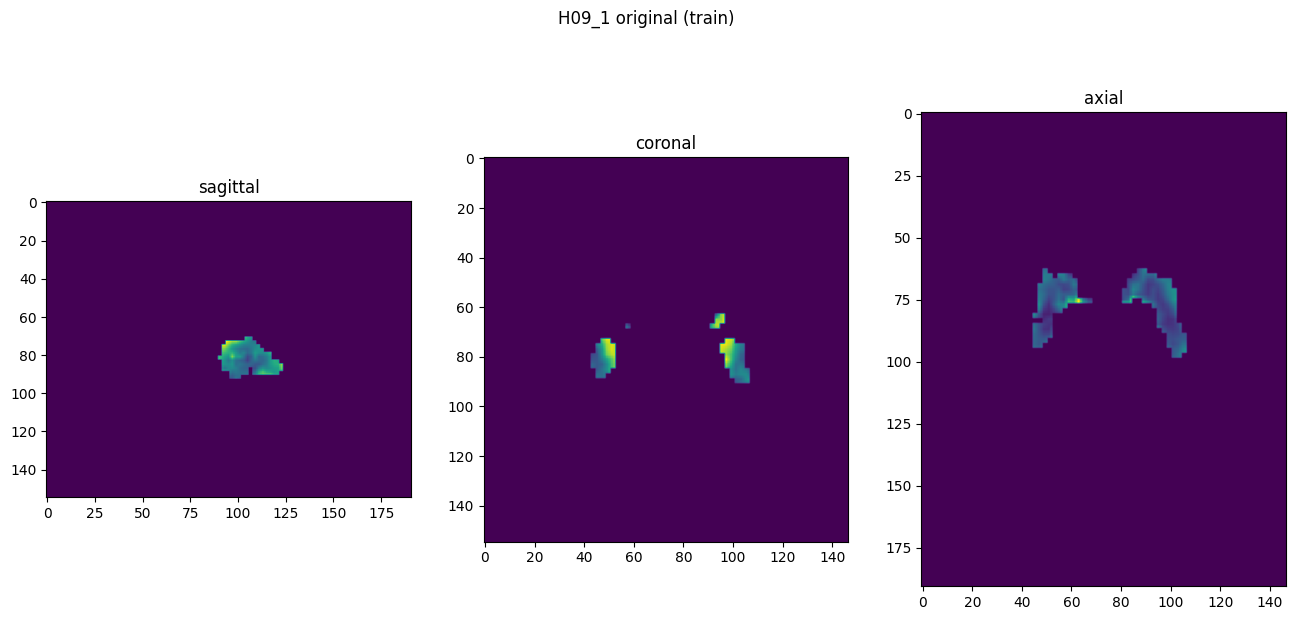

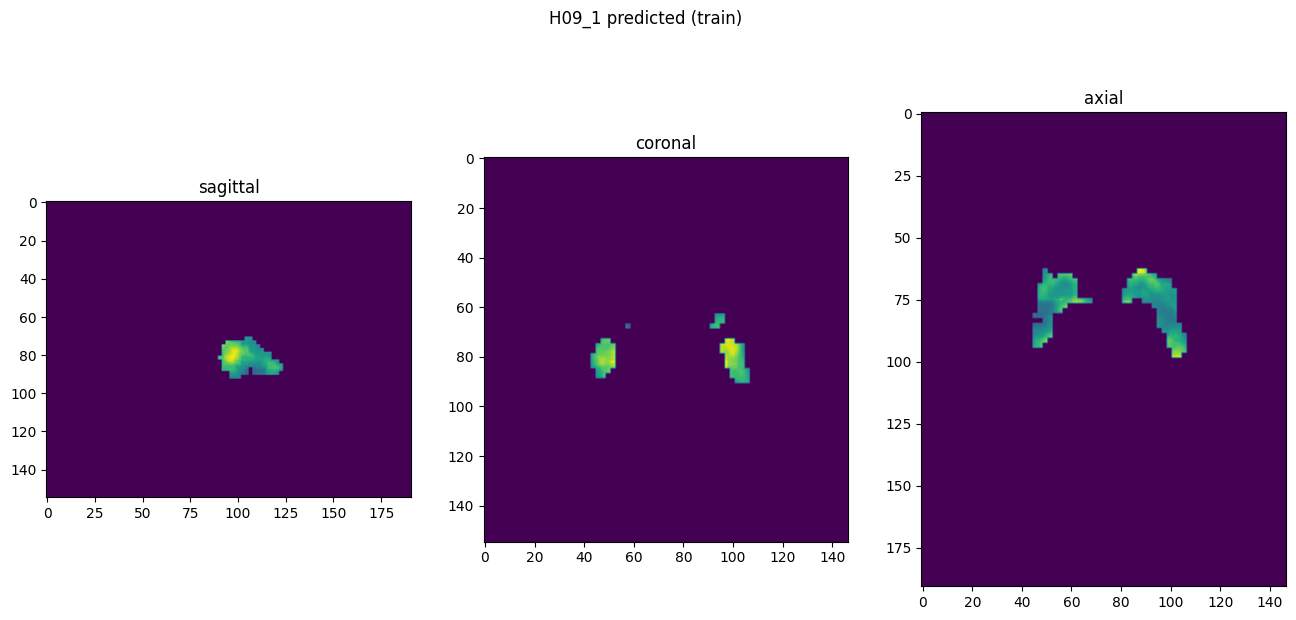

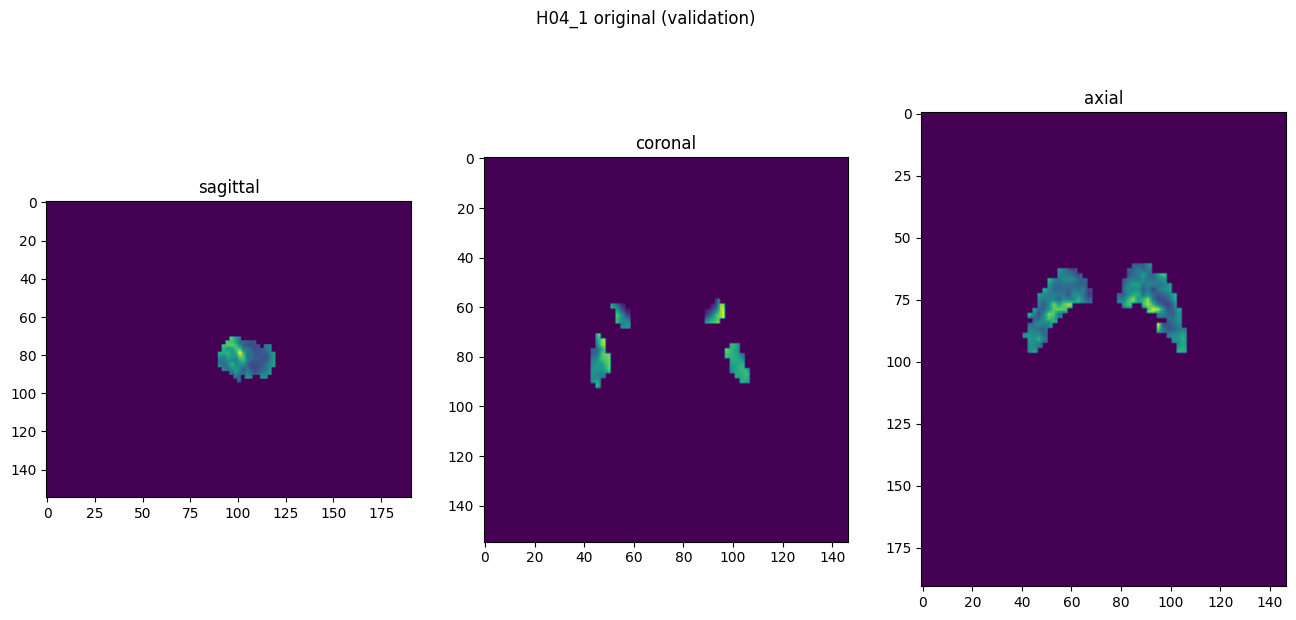

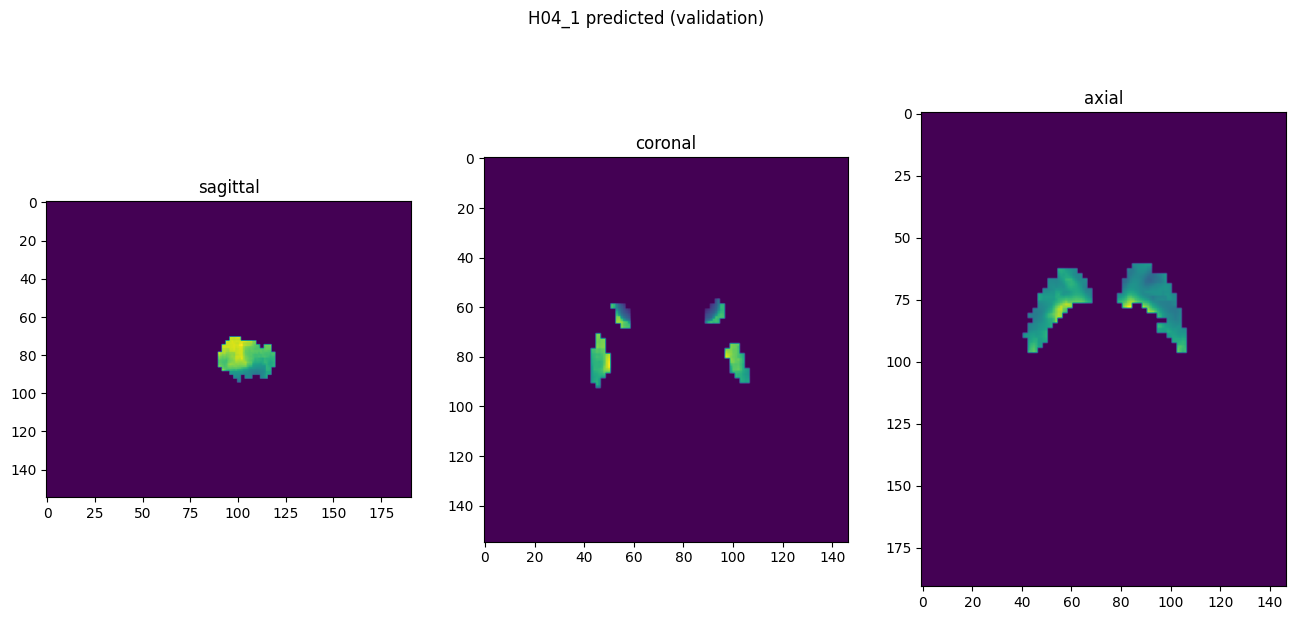

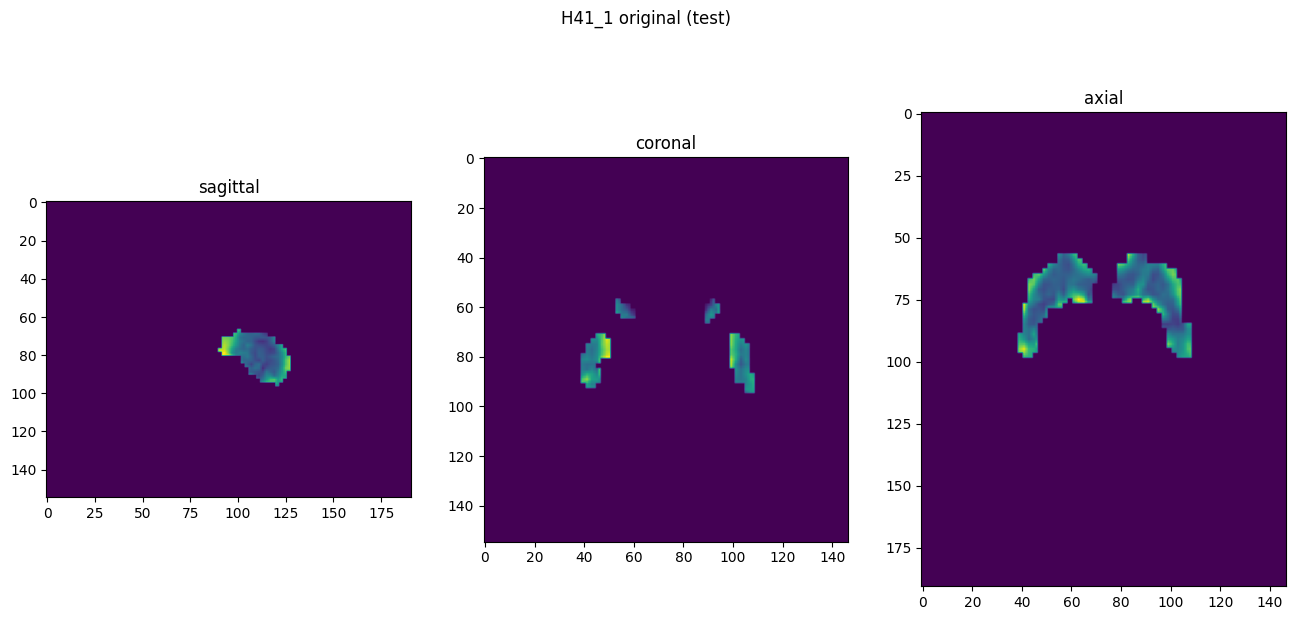

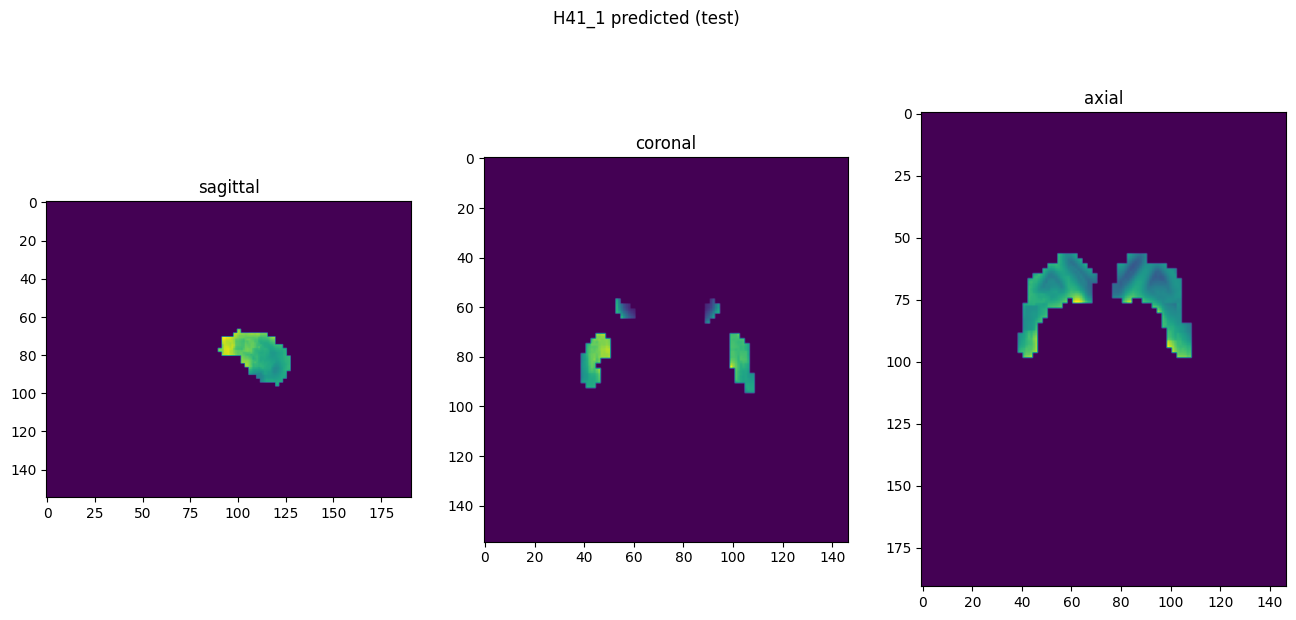

In [10]:
showResults(model, gen, threshold=None, background=False)